Notebook created by [Saku Peltonen](https://disco.ethz.ch/members/besterma)

In [ ]:
# Uncomment for Colab
!pip install pytorch-fid

# Introduction to Unsupervised Representation Learning and Generative Models

In this notebook, we will explore the basics of representation learning and how it can be implemented in PyTorch. Representation learning is a powerful technique in the field of machine learning that involves learning a compact and meaningful representation of raw data, such as images, audio, text, and other types of complex data. The main goal of representation learning is to extract the most important and informative features from the input data, which can be further used for various downstream tasks such as classification, clustering, and prediction.

The key idea behind representation learning is that by learning a good representation of data, we can simplify the problem of learning complex functions that map inputs to outputs. Instead of relying on hand-crafted features or domain-specific knowledge, representation learning algorithms aim to automatically learn the features that are most relevant for the task at hand. This is achieved by training a model to extract features that are useful for a given task, while also minimizing the amount of noise or irrelevant information that may be present in the input data.




 Representation learning is a subfield of machine learning that focuses on learning compact and meaningful representations of data, often for the purpose of reducing dimensionality, improving generalization, or facilitating transfer learning.

What is a good representation? It generally is one that makes a subsequent learning task easier.

We will start by loading the necessary libraries and setting the device for our computations.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torchvision
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

Next, let's load and preprocess the data. At the beginning, we'll use the MNIST dataset, which you have already encountered in the final task of the first session.
It consists of 28x28 grayscale images of handwritten digits.

In [ ]:
from torchvision.datasets import MNIST

mnist_train = MNIST("./data", train=True, download=True,
                    transform=torchvision.transforms.ToTensor())
mnist_test = MNIST("./data", train=False, download=True,
                  transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=True)

Let us first visualize our dataset again.

**Exercise** Plot a set of random samples of the dataset with the corresponding label in a grid

In [ ]:
# Get an iterator
dataiter = iter(train_loader)
# You can get a random image with label by calling next() on the iterator
images, labels = next(dataiter)

#Now plot the images in a grid
# Define grid size (e.g., 4x8 for 32 images)
grid_size = (4, 8)  # Adjust as necessary based on batch size
num_images = grid_size[0] * grid_size[1]

# Create a grid of images
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 6))

# Loop through the grid and plot the images
for i, ax in enumerate(axes.flat):
    if i < len(images):  # Ensure we don't exceed the batch size
        img = images[i].squeeze().numpy()  # Remove channel dimension and convert to numpy
        ax.imshow(img, cmap='gray')  # Plot the image in grayscale
        ax.set_title(f"{labels[i].item()}", fontsize=10)  # Display the label
        ax.axis('off')  # Hide axes for better visualization
    else:
        ax.axis('off')  # Turn off unused axes

plt.tight_layout()
plt.show()

Now that we have the data, let us define the first model architecture.

## Autoencoder
An autoencoder is a type of neural network that is trained to learn a compressed representation of input data, which is then used to reconstruct the original input. The autoencoder consists of two main parts: an encoder and a decoder.

 * The **encoder** takes the input data and maps it to a lower-dimensional representation, which is also called a latent space. This mapping process can be thought of as compressing the input data. The size of the latent space is typically smaller than the size of the input data, so the encoder is essentially learning to extract the most important features of the input data and discard the rest.



 * The **decoder** takes the compressed representation and maps it back to the original input dimensionality. This process can be thought of as decompressing the data. The decoder learns to reconstruct the original input from the compressed representation.



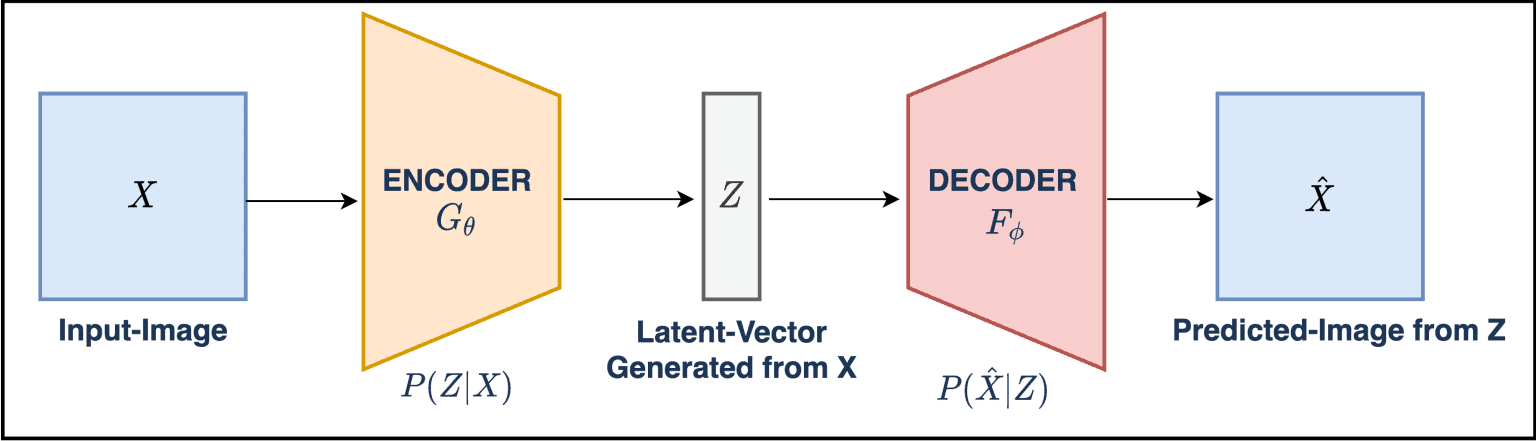

Image taken from [learnopencv.com](https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/)



During training, the autoencoder is optimized to minimize the difference between the original input and the reconstructed output. This is typically done by minimizing a loss function that measures the difference between the original input and the reconstructed output. This loss function can be a simple mean squared error (MSE) or a more complex function such as binary cross-entropy, depending on the nature of the input data. We call this the reconstruction loss.

The training of an autoencoder is different from classical supervised training in that it is an unsupervised learning technique. This means that the autoencoder is trained on unlabelled data, and there is no explicit target output for the network to learn from. Instead, the network learns to reconstruct the input data based solely on the patterns it finds in the input data.


Now that we know what an autoencoder is, let us explore how it works in practice.

We first define our **encoder**. This architecture might look familiar, as it is very similar to the architecture you have seen in the last notebook, called `MultiLayerCNN`. The encoder will compress the input into a **latent space** of size `encoding_dim`.




In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(num_features=10)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        self.fc1 = nn.Linear(320, encoding_dim)

    def forward(self, x):
        x = self.pool(nn.functional.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.leaky_relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return x

Next, we need to define our **decoder**. Previously, we have used the convolution operation in combination with pooling for dimensionality reduction, i.e. the output image becomes smaller than the input image.

The "inverse" operation is called **deconvolution**, also known as fractionally-strided convolution or transposed convolution. It is an operation in which a convolutional kernel is used to upsample a given input image, resulting in an output image that is larger than the input image.


ConvTranspose2d layer performs the opposite operation of Conv2d layer in PyTorch. The operation of ConvTranspose2d layer can be thought of as "unfolding" the input feature maps into a larger space, and then applying a set of filters to obtain the output feature maps. The size of the output feature maps is determined by the size of the filters used in the ConvTranspose2d layer.

As a quick summary, this is how a convolution works. Blue squares are input and green squares are the output.


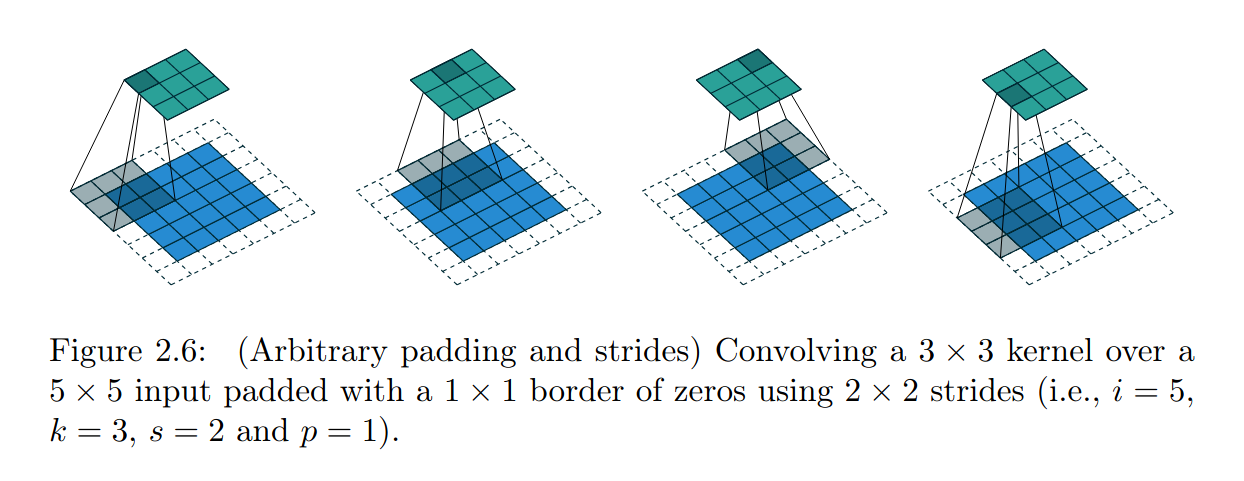
Image credit to [arxiv.org/pdf/1603.07285.pdf](https://arxiv.org/pdf/1603.07285.pdf)

A transposed convolution works by getting a small input (blue) and transforming it into a larger output (green).

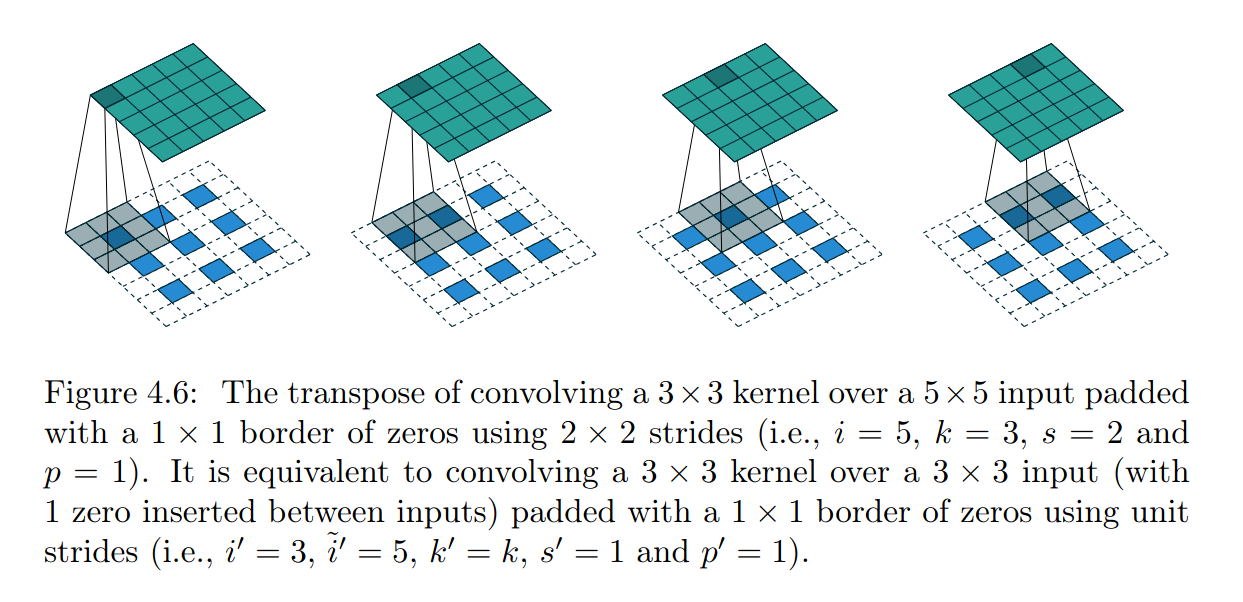
Image credit to [arxiv.org/pdf/1603.07285.pdf](https://arxiv.org/pdf/1603.07285.pdf)

In pytorch, this works the following way:

In [ ]:
# Define random input tensor
x = torch.randn(1, 1, 3, 3)  # Batch size = 1, 1 input channels, 3x3 input size

# Define ConvTranspose2d layer
conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=6, kernel_size=3, stride=2, padding=1)

# Perform forward pass
output = conv_transpose(x)

# Print input and output tensor shapes
print(f"Input tensor shape: {x.shape}")
print(f"Output tensor shape: {output.shape}") # Batch size = 1, 6 output channels, 5x5 output size

In our case, we need the ConvTranspose2d layers as part of our decoder to get from the small latent space back to a full sized image.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Decoder, self).__init__()

        self.fc2 = nn.Linear(encoding_dim, 320)
        self.conv3 = nn.ConvTranspose2d(in_channels=20, out_channels=10,
                                        kernel_size=6, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=10)
        self.conv4 = nn.ConvTranspose2d(in_channels=10, out_channels=1,
                                        kernel_size=6, stride=2)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc2(x))
        x = x.view(-1, 20, 4, 4)
        x = self.bn1(nn.functional.leaky_relu(self.conv3(x)))
        x = torch.sigmoid(self.conv4(x))
        return x


Note that we are using batch normalization in both the encoder and the decoder. Batch normalization (BatchNorm) is a technique used in deep neural networks to improve the training speed and stability of models. This is especially helpful once the model becomes deeper, for example our autoencoder.

The basic idea behind BatchNorm is to normalize the batched input to each layer of a neural network to have zero mean and unit variance across the batch dimension, using statistics computed over the current mini-batch during training. This has the effect of centering the activations of the layer around zero and rescaling them to a similar scale, which can help prevent the saturation of activation functions and the vanishing gradient problem.

BatchNorm is typically applied after the linear transformation and before the activation function of each layer in the neural network.

Notice that we also use leaky_relu as activation function. Leaky relu works the following way, with alpha usually being very small (e.g. 0.01).
```
f(x) = { x,                  if x >= 0
       { alpha * x,           if x < 0
```
Together with batch normalization, it helps keeping the gradients stable.

Finally, let us define our complete autoencoder:



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(encoding_dim)
        self.decoder = Decoder(encoding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We replicate the training loop from earlier notebooks with a few small changes. Note that we are not using any labels from the dataloader and compute our loss on the input images (`features`), and the reconstructed images of the model (`out`)



In [ ]:
def train_ae_epoch(net, dataloader, lr=0.0001, optimiser=None, loss_fn = nn.MSELoss(),
                device="cuda"):
    optimiser = optimiser or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc,count = 0,0,0
    for features,_ in dataloader:
        features = features.to(device)
        out = net(features)
        loss = loss_fn(out, features)
        total_loss += loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        count += len(features)
    return total_loss/count


**Exercise** Define and train the autoencoder for ~8 epochs. Start out with a latent dimension (`encoding_dim`) of 8, and see what happens with the reconstruction loss during training and the evaluation if you make the latent dimension very small or very large (eg 2 or 32). Make sure name each model differently as later on we want to compare their respective performance.

To visualize how training progresses, after every training epoch store an image that gets reconstructed by the model.
In the end, plot all these images in a line.

To not compute any gradients when reconstructing the images, you can wrap your code:

```
with torch.no_grad():
  #reconstruct your images here
```
Of course you are open to extend your code to log more images.


In [ ]:
original_images = [] #put all original images in this list
reconstructed_images = [] #put all reconstructed images in this list
#assert len(original_images) > 0, "Please put some images in the original_images list"

encoding_dims = [2,8,32]

for dim in encoding_dims:
    print(f"Training autoencoder with latent dimension: {dim}")
    autoencoder = Autoencoder(dim).to(device)

    for epoch in range(8):
        loss = train_ae_epoch(autoencoder, train_loader, device=device)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    # Save original and reconstructed images
    with torch.no_grad():
        autoencoder.eval()
        dataiter = iter(train_loader)
        images, _ = next(dataiter)
        images = images.to(device)
        reconstructed = autoencoder(images)

        # Save a few samples for visualization
        original_images.append(images[0])
        reconstructed_images.append(reconstructed[0])


#Your code  
assert len(original_images) == len(reconstructed_images), "Please reconstruct all original images"
fig, axs = plt.subplots(2, len(original_images), figsize=(20, 5))
fig.suptitle('MNIST Dataset Examples')
for j, (original_image, reconstructed_image) in enumerate(zip(original_images, reconstructed_images)):
    image, label = next(dataiter)
    axs[0,j].imshow(np.squeeze(original_image.cpu().numpy()), cmap='gray')
    axs[1,j].imshow(np.squeeze(reconstructed_image.cpu().numpy()), cmap='gray')
    axs[0,j].set_title(str(j))
    axs[0,j].axis('off')
    axs[1,j].axis('off')

plt.show()

## Evaluation
Of course we can also evaluate our model on the test set. We can do this in two ways:


*   **Quantitatively** by looking at the reconstruction loss. This gives us a good overall picture and allows us to easily compare different models
*   **Qualitatively** by looking at the latent space and examples of reconstructed images.



### Quantitative Evaluation

In [ ]:
def validate_ae(net, dataloader,loss_fn=nn.MSELoss()):
    net.eval()
    count,loss, total_loss = 0,0,0
    with torch.no_grad():
        for features,_ in dataloader:
            features = features.to(device)
            out = net(features)
            loss = loss_fn(out, features)
            total_loss += loss.item()
            count += len(features)
    return loss.item()/count

**Exercise** Compute the reconstruction loss of the model on the training and the test set. Compare how the models with different sized latent space perform.

In [ ]:
# Your code
model_small = Autoencoder(encoding_dims[0]).to(device)
model_medium = Autoencoder(encoding_dims[1]).to(device)
model_large = Autoencoder(encoding_dims[2]).to(device)

#Compute loss reconstruction loss on training data
loss_small = train_ae_epoch(model_small,train_loader,device=device)
loss_medium = train_ae_epoch(model_medium,train_loader,device=device)
loss_large = train_ae_epoch(model_large,train_loader,device=device)

#Compute validation loss on test set
val_loss_small = validate_ae(model_small,test_loader)
val_loss_medium = validate_ae(model_medium,test_loader)
val_loss_large = validate_ae(model_large,test_loader)

#Compare models
print(f"Model Encoding Dimenson: {encoding_dims[0]}, Loss: {loss_small + val_loss_small:.4f}")
print(f"Model Encoding Dimenson: {encoding_dims[1]}, Loss: {loss_medium + val_loss_medium:.4f}")
print(f"Model Encoding Dimenson: {encoding_dims[2]}, Loss: {loss_large + val_loss_large:.4f}")


### Qualitative Evaluation
We can also visualize the latent space of the model. As the latent space usually is larger than 2, we will use a dimensionality reduction technique called t-SNE to project our latent space in two dimensions.

**Exercise** Run the cell below for AEs with different latent space sizes, store the outputs and discuss with a colleague or a TA what this plot tells us.

In [ ]:
# Visualize the learned representations in 2D using t-SNE
viz_loader = torch.utils.data.DataLoader(mnist_test, batch_size=2000, shuffle=True)
from sklearn.manifold import TSNE
with torch.no_grad():
    features, targets = next(iter(viz_loader))
    z = model_large.encoder(features.to(device))
    z = z.detach().cpu().numpy()
    tsne = TSNE()
    z_tsne = tsne.fit_transform(z)

plt.figure(figsize=(14,11))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=targets, cmap="tab10", alpha=0.7)
plt.colorbar()
plt.show()

**Exercise** To get a better feeling how good the reconstructions of the model are, plot some random images of the mnist dataset along with the reconstructions of the model

In [ ]:
# Your code

#Small model
with torch.no_grad():
 images, labels = next(dataiter)
 images = images.to(device)
 reconstructed = model_small(images)
 original_images = [images[i] for i in range(5)]
 reconstructed_images = [reconstructed[i] for i in range(5)]

fig, axs = plt.subplots(2, len(original_images), figsize=(20, 5))
fig.suptitle('MNIST Dataset Examples: Small Model')
for j, (original_image, reconstructed_image) in enumerate(zip(original_images, reconstructed_images)):
    image, label = next(dataiter)
    axs[0,j].imshow(np.squeeze(original_image.cpu().numpy()), cmap='gray')
    axs[1,j].imshow(np.squeeze(reconstructed_image.cpu().numpy()), cmap='gray')
    axs[0,j].set_title(str(j))
    axs[0,j].axis('off')
    axs[1,j].axis('off')

#Medium Model
with torch.no_grad():
 images, labels = next(dataiter)
 images = images.to(device)
 reconstructed = model_medium(images)
 original_images = [images[i] for i in range(5)]
 reconstructed_images = [reconstructed[i] for i in range(5)]

fig, axs = plt.subplots(2, len(original_images), figsize=(20, 5))
fig.suptitle('MNIST Dataset Examples: Medium Model')
for j, (original_image, reconstructed_image) in enumerate(zip(original_images, reconstructed_images)):
    image, label = next(dataiter)
    axs[0,j].imshow(np.squeeze(original_image.cpu().numpy()), cmap='gray')
    axs[1,j].imshow(np.squeeze(reconstructed_image.cpu().numpy()), cmap='gray')
    axs[0,j].set_title(str(j))
    axs[0,j].axis('off')
    axs[1,j].axis('off')

#Large Model
with torch.no_grad():
 images, labels = next(dataiter)
 images = images.to(device)
 reconstructed = model_large(images)
 original_images = [images[i] for i in range(5)]
 reconstructed_images = [reconstructed[i] for i in range(5)]

fig, axs = plt.subplots(2, len(original_images), figsize=(20, 5))
fig.suptitle('MNIST Dataset Examples: Large Model')
for j, (original_image, reconstructed_image) in enumerate(zip(original_images, reconstructed_images)):
    image, label = next(dataiter)
    axs[0,j].imshow(np.squeeze(original_image.cpu().numpy()), cmap='gray')
    axs[1,j].imshow(np.squeeze(reconstructed_image.cpu().numpy()), cmap='gray')
    axs[0,j].set_title(str(j))
    axs[0,j].axis('off')
    axs[1,j].axis('off')


## Using the representation for a downstream task
### Clustering
We can use the latent space of our autoencoder to cluster together similar images. If our autoencoder has learned a good latent representation, images that are similar in the latent space should have similar properties, for example they should show the same number.

Lets put this to the test.

**Exercise** Compare the different models you have tried out so far or different input images that you have seen could be challenging. How do they do?

In [ ]:
# You are given the following image
image, label = mnist_train[523]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(str(label))
plt.show()

print(image.shape)

In [ ]:
# We will use a separate loader as to not shuffle the data.
cluster_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32)

cluster_model = model_small.to(device) # Define the model to use

cluster_model.eval()

with torch.no_grad():
    latent = cluster_model.encoder(image.unsqueeze(0).to(device))

distances = []
for images, labels in cluster_loader:
    with torch.no_grad():
        batch_latent = cluster_model.encoder(images.to(device))
        # torch.cdist gives us the 2-norm distance between the respective latent vectors
        batch_distances = torch.cdist(batch_latent, latent)
    distances.append(batch_distances)

distances = torch.cat(distances)

_, indices = distances.squeeze().sort()

indices = indices.to("cpu")

# Plot the 10 closest images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(14,4))
for i in range(10):
    image, label = mnist_test[indices[i]]
    ax[i//5, i%5].imshow(image.squeeze().numpy(), cmap='gray')
    ax[i//5, i%5].set_title(f"Distance: {distances[indices[i]].item():.2f}")

    ax[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

### Feature extraction
Assume that we have access to all training images in MNIST, but only for a small part of them we actually know the label. First, let us see how well we perform by directly training a classifier on only 200 images.

We can use the training and validation loops from the computer vision notebook to train our classifier:



In [ ]:
import time

def train_epoch(net, dataloader, lr=0.01, optimiser=None, loss_fn = nn.NLLLoss()):
    optimiser = optimiser or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc,count = 0,0,0
    for features,labels in dataloader:
        out = net(features)
        loss = loss_fn(out, labels)
        total_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net, train_loader, test_loader, optimiser=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimiser = optimiser or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimiser=optimiser,lr=lr,loss_fn=loss_fn)
        if ep % 10 == 0 and ep > 0:
            end_time = time.time() # end time of 10 epochs
            epoch_time = end_time - start_time # time taken for 10 epochs
            vl,va = validate(net,test_loader,loss_fn=loss_fn)
            print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}, time taken={epoch_time:.2f}s")
            res['val_loss'].append(vl)
            res['val_acc'].append(va)
            start_time = time.time() # start time of next 10 epochs
        else:
            print(f"Epoch {ep:2}, Train acc={ta:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)

    return res

class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x


**Exercise** In the next cell you are given a train loader that includes only a limited number of samples. Train a MultiLayerCNN classifier for 10-20 epochs and print its test accuracy.

In [ ]:
import torch.utils.data.sampler as sampler
import random

# set random seed for reproducibility
np.random.seed(42)

indices = np.random.choice(len(mnist_train), size=64, replace=False)

# create a new dataset containing only the selected indices
mnist_train_subset = torch.utils.data.Subset(mnist_train, indices)

train_loader_subset = torch.utils.data.DataLoader(mnist_train_subset, batch_size=32, shuffle=True)


In [ ]:
# Train your classifier here

classifier = MultiLayerCNN()
loss = train(classifier,train_loader_subset,test_loader,epochs=100)
print(f"The model accuracy is {np.max(loss['val_acc'])}")

As you can see with only a very low number of labeled images, the network overfits on the training data. Because MNIST is very simple, the model still achieves a respectable validation loss.

But do we have an alternative to just training a classifier on the few images we have?


Yes, we can use the encoder of the autoencoder we have trained previously to provide us with easier features. This way, the classifier does not need to understand our high-dimensional input images, but it can work on the much simpler latent space of our autoencoder.

In other words, if we want to classify an image, we first run it through the encoder of our AE. This gives us a tensor with size `encoding_dim`. We then provide this tensor to the classifier to classify the image.

**Exercise** Extend the functions `train_epoch`, `validate` and `train` from above so that you can optionally provide an encoder that gets applied to the images. The classifier then gets fed the latent representation of the encoder applied on the images.

In [ ]:
# Your function signatures should look like this:
# If encoder == None, the behaviour should not change
def train_epoch(net, dataloader, lr=0.01, optimiser=None, loss_fn = nn.NLLLoss(), encoder=None):
  optimiser = optimiser or torch.optim.Adam(net.parameters(), lr=lr)
  net.train()
  total_loss, acc,count = 0,0,0
  for features,labels in dataloader:
        if encoder is not None:
          features = encoder(features) # If the encode is None, we proceed as before. Else we encode features to another simples latent space
        out = net(features)
        loss = loss_fn(out, labels)
        total_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
  return total_loss.item()/count, acc.item()/count
  

def validate(net, dataloader,loss_fn=nn.NLLLoss(), encoder=None):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            if encoder is not None:
               features = encoder(features)
            out = net(features)
            loss += loss_fn(out,labels)
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net, train_loader, test_loader, optimiser=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss(),
          encoder=None):
    optimiser = optimiser or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimiser=optimiser,lr=lr,loss_fn=loss_fn,encoder=encoder)
        if ep % 10 == 0 and ep > 0:
            end_time = time.time() # end time of 10 epochs
            epoch_time = end_time - start_time # time taken for 10 epochs
            vl,va = validate(net,test_loader,loss_fn=loss_fn,encoder=encoder)
            print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}, time taken={epoch_time:.2f}s")
            res['val_loss'].append(vl)
            res['val_acc'].append(va)
            start_time = time.time() # start time of next 10 epochs
        else:
            print(f"Epoch {ep:2}, Train acc={ta:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)

    return res

We define a classifier. Comparied to our `MultilayerCNN` classifier, this one can be much simpler as it already recieves a low-dimensional input.

In [ ]:
# Define a simple classifier, as the Autoencoder will do the heavy lifting
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.log_softmax(self.fc2(x), dim=1)
        return x


**Exercise** Similar to how you have trained the `MultiLayerCNN` classifier, train now `SimpleClassifier` using the limited training data available in `train_loader_subset`. Use the encoder of an autoencoder you have trained previously. You can select with autoencoder you want to use by assigning it to `clf_ae`. Explore with how many epochs you have to train the classifier.

***Tip*** Make sure the encoder you are using is trained well. An encoding_dim of 8 seemed to work best.

In [ ]:
encoding_dim = 8 #
clf_ae = model_medium # Define the model you want to use
classifier = SimpleClassifier(encoding_dim, 30, 10) # The first argument is the latent dimension of your encoder, make sure this is correct.

# We want to make a deep copy of the encoder we have trained earlier as to not change anything.

encoder = Encoder(encoding_dim=encoding_dim)
encoder.load_state_dict(clf_ae.encoder.state_dict())

# Freeze the encoder
for param in encoder.parameters():
    param.requires_grad = False

# Your code here (remember to use the train_loader_subset)
loss = train(classifier,train_loader_subset,test_loader,encoder=encoder,epochs=200)
print(f"The model accuracy is {np.max(loss['val_acc'])}")

As you can see, the very simple classifier trained on the latent space of the autoencoder is not doing too bad. If the autoencoder is trained well enough, the simple classifier can even surpass the accuracy of the `MultilayerCNN classifier`. Further, because our encoder is frozen, we need much less computational resources to train our classifier.

Now that we have seen what an AE is, how it works, and how we can make use of the latent representation it provides us with, lets look at a slightly more complex version of the AE.

## Variational Autoencoders (VAEs)
A Variational Autoencoder (VAE) is a type of neural network that builds on the idea of an Autoencoder (AE). Like an AE, a VAE also learns to encode and decode data, but it does so in a probabilistic manner.

While an AE learns a deterministic mapping from input data to a compressed latent representation, a VAE learns a probability distribution over the latent space. This means that instead of encoding input data into a fixed, deterministic code, a VAE encodes input data into a probability distribution over the latent space. It does this by predicting a mean μ and a variance Σ of a normal distribution for every dimension in its latent space. During reconstruction, the value that gets fed into the decoder is sampled from this distribution.


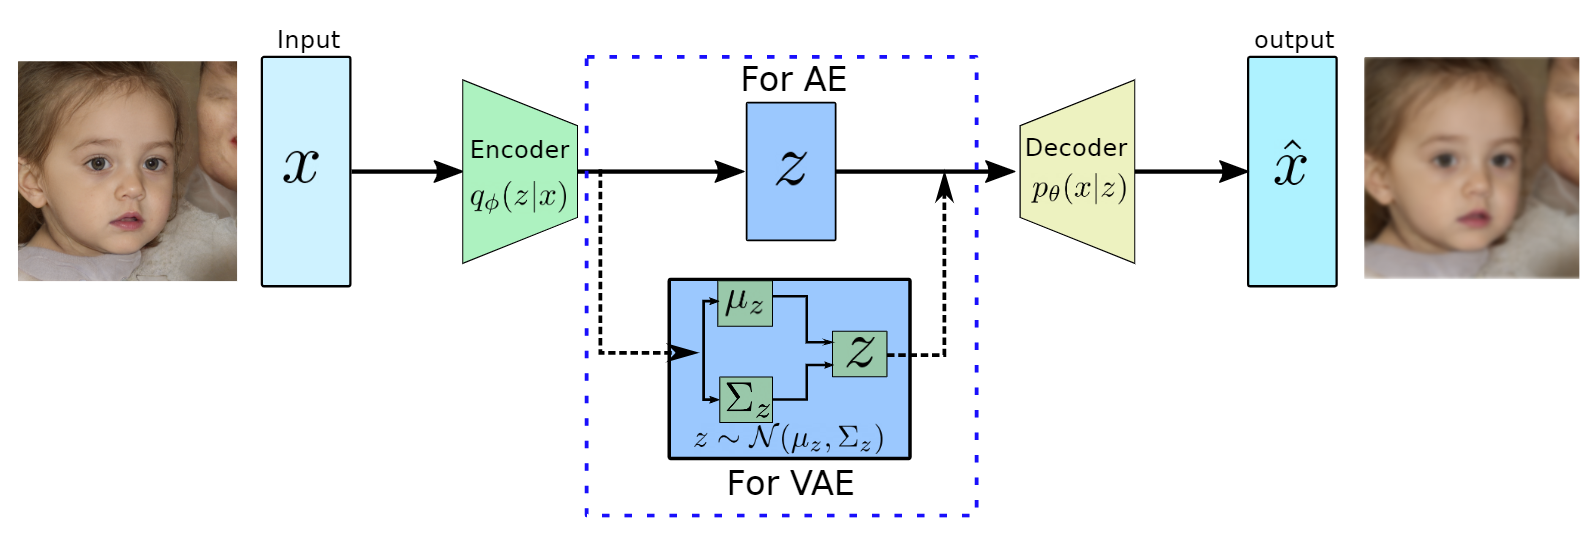
Image from [brunomaga.github.io/](https://https://brunomaga.github.io/)

The key innovation of a VAE is that it uses a reparameterization trick to sample from the learned probability distribution during training to pass the gradients. In this notebook, we will not focus on how it exactly works, but you will encounter it in the `reparameterize` function in the code.

Another important feature of a VAE is the use of a loss function that encourages the learned probability distribution to match a prior distribution, typically a standard Gaussian distribution. This loss function contains two terms: the **reconstruction loss**, which measures how well the decoded data matches the original input, and the **KL divergence loss**, which measures how closely the learned probability distribution matches the prior distribution. In our case, the prior distribution is a standard normal distribution.

The following plot should give you some intuition on how KL-divergence works.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the parameters for the first distribution (low KL-divergence to the second distribution)
mu1 = 0
sigma1 = 1

# Define the parameters for the second distribution (low KL-divergence to the first distribution)
mu2 = 0.2
sigma2 = 1

# Define the parameters for the third distribution (high KL-divergence to the fourth distribution)
mu3 = 0
sigma3 = 1

# Define the parameters for the fourth distribution (high KL-divergence to the third distribution)
mu4 = 2
sigma4 = 1

# Define the x-axis range
x = np.linspace(-5, 5, 1000)

# Compute the probability density function (PDF) for the first distribution
pdf1 = norm.pdf(x, mu1, sigma1)

# Compute the probability density function (PDF) for the second distribution
pdf2 = norm.pdf(x, mu2, sigma2)

# Compute the probability density function (PDF) for the third distribution
pdf3 = norm.pdf(x, mu3, sigma3)

# Compute the probability density function (PDF) for the fourth distribution
pdf4 = norm.pdf(x, mu4, sigma4)

# Compute the KL-divergence between the first and second distributions
kl1 = np.round(np.sum(np.where(pdf1 != 0, pdf1 * np.log(pdf1 / pdf2), 0)), 3)

# Compute the KL-divergence between the third and fourth distributions
kl2 = np.round(np.sum(np.where(pdf3 != 0, pdf3 * np.log(pdf3 / pdf4), 0)), 3)

# Plot the first two distributions on the left side

fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].plot(x, pdf1, label='Distribution 1')
ax[0].plot(x, pdf2, label='Distribution 2')
ax[0].set_title(f"Low KL-Divergence: {kl1}")

# Plot the last two distributions on the right side

ax[1].plot(x, pdf3, label='Distribution 3')
ax[1].plot(x, pdf4, label='Distribution 4')
ax[1].set_title(f"High KL-Divergence: {kl2}")

plt.show()

By optimizing both reconstruction loss and KL-divergence loss, a VAE can learn a continuous and structured latent space that can be used to generate new data points, perform data compression, and even perform various types of data manipulation, such as image morphing and style transfer.

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoding_dim):
        super(VAE, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = Encoder(encoding_dim*2)
        self.decoder = Decoder(encoding_dim)

    def encode(self, x):
        x = self.encoder(x)
        mu, log_var = x.split(self.encoding_dim, dim=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

We adapt our training function for VAE training by including the kl-divergence loss (`kl_loss`).

In [ ]:
def train_vae_epoch(net, dataloader, lr=0.0001, optimiser=None,
                    recon_loss_fn=nn.MSELoss(reduction='sum'), device="cuda"):
    optimiser = optimiser or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, total_recon_loss, total_kl_loss,count = 0,0,0,0
    for features,_ in dataloader:
        features = features.to(device)
        out, mu, log_var = net(features)
        recon_loss = recon_loss_fn(out, features)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())
        loss = recon_loss + kl_loss
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        count += len(features)
    return total_loss/count, total_recon_loss/count, total_kl_loss/count

**Exercise** Like earlier with the AE, train now a VAE and log some reconstructed images during the training. Note that if you train for ~6 epochs, training will take a few minutes.

*Tip* To keep the two losses balanced, provide the argument `reduction='sum'` to the reconstruction loss

In [ ]:
# Your code
vae_medium = VAE(encoding_dim).to(device)
result = {'total_loss':[], 'recon_loss': [], 'kl_loss': []}
for i in range(5):
    tot, rl, kl = train_vae_epoch(vae_medium,train_loader,device=device)
    result['total_loss'].append(tot)
    result['recon_loss'].append(rl)
    result['kl_loss'].append(kl)
    print(f"Epoch:{i}, Total Loss: {tot:4f}, Reconstruction Loss: {rl:4f}, KL-Divergence Loss: {kl:4f}")

Similar to the autoencoder, we can reconstruct some images to see how well our VAE does.

In [ ]:
dataiter = iter(train_loader)
features, labels = next(dataiter)
model_to_visualize = vae_medium  # Provide your model here


model_to_visualize.eval()
fig, axs = plt.subplots(2, 15, figsize=(10, 2.5))
fig.suptitle('Reconstructions')
for i in range(15):
    with torch.no_grad():
      features = features.to(device)
      axs[0,i].imshow(np.squeeze(features[i].detach().cpu().numpy()), cmap='gray')
      axs[1,i].imshow(np.squeeze(model_to_visualize(features)[0][i].detach().cpu().numpy()), cmap='gray')
      axs[0,i].set_title(str(labels[i].item()))
      axs[0,i].axis('off')
      axs[1,i].axis('off')

plt.show()


# Plot the images in a 2x5 grid

As we have done with the AE earlier, we can visualize the latent space of the VAE. Note that we need to sample from the latent distribution by doing reparameterization. Alternatively, we could also just use the outputted mean `mu` of the encoder.

In [ ]:
# Visualize the learned representations in 2D using t-SNE
viz_loader = torch.utils.data.DataLoader(mnist_test, batch_size=4000, shuffle=True)
from sklearn.manifold import TSNE
with torch.no_grad():
    features, targets = next(iter(viz_loader))
    mu, logvar = model.encode(features.to(device))
    z = model.reparameterize(mu, logvar)
    z = z.detach().cpu().numpy()
    tsne = TSNE()
    z_tsne = tsne.fit_transform(z)

plt.figure(figsize=(14,11))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=targets, cmap="tab10", alpha=0.7)
plt.colorbar()
plt.show()

Stop for a second and compare the plot of the latent space to the one from the autoencoder. What difference do you notice and what is it probably caused by?


*Solution* Due to the KL-Divergence loss, the latent space is much less sparse than the latent space of an autoencoder.

### Image generation
Because our latent space is much more densely populated, we can now actually sample a vector from our prior distribution and use this as an input to our decoder.

In [ ]:
vae_sampling = vae_medium

vae_sampling.eval()

latent_tensor = torch.randn(64, encoding_dim).to(device)

with torch.no_grad():
  # generate images using the generator
  generated_images = vae_sampling.decode(latent_tensor)

# reshape the generated images into a grid
generated_images = generated_images.view(64, 1, 28, 28)
grid_fake = torchvision.utils.make_grid(generated_images, nrow=8, padding=2)

# Sample 64 images from the train loader
samples = []
for i, (data, target) in enumerate(train_loader):
    samples.append(data)
    if i*train_loader.batch_size >= 64:
        break

# concatenate the samples into a single tensor
original_images = torch.cat(samples, dim=0)

grid_orig = torchvision.utils.make_grid(original_images[:64], nrow=8, padding=2)

# convert the grid to a numpy array and display it
grid_fake = grid_fake.permute(1, 2, 0).detach().cpu().numpy()
grid_orig = grid_orig.permute((1, 2, 0)).cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(grid_orig)
ax[0].set_title('Original Images')
ax[1].imshow(grid_fake)
ax[1].set_title('Generated Images')
plt.show()


As you can see the generated images do not look perfect, but they look similar to our training data. There is a way to quantify exactly how similar the generated images are to the training data distribution, it is a metric called FID.

### Fréchet Inception Distance (FID)
The Fréchet Inception Distance (FID) score is a metric for evaluating the quality of generative models, such as GANs and VAEs. It was introduced by Martin Heusel et al. in their 2017 paper "GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium". The FID score is based on the idea that a good generative model should produce images that are both visually similar to the real images and have similar statistics to the real images in the feature space of a pre-trained deep neural network.

Here's how the FID score works (you don't need to understand the details):

1.    A pre-trained deep neural network, such as InceptionV3, is used to extract feature vectors from both the real and generated images.
2.    The mean and covariance of the feature vectors are computed for both the real and generated images.
3.    The distance between the mean vectors is computed using the squared Euclidean distance.
4.    The trace of the product of the covariance matrices is computed.
5.    The FID score is the sum of the squared Euclidean distance and the trace of the product of the covariance matrices, minus some constants.


The FID score can be interpreted as a measure of the difference between the real and generated images in the feature space of a pre-trained deep neural network. A **lower** FID score indicates that the **generated images are more similar** to the real images in this feature space, and thus are of **higher quality.** However, it's important to note that the FID score is not a perfect metric for image quality, and should be used in combination with other metrics and human judgement to evaluate the quality of generative models.

For our VAE we can now compute the FID score of its generated images the following way:
To compute the FID of the generated images of our VAE, we need to store a set of generated images and a set of original images in a folder. After that, we can use the python module `pytorch_fid` to compute the FID.


In [ ]:
import os
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import shutil

def store_tensor_to_folder(tensor, folder):
    # Delete the folder to make sure we don't have duplicate images
    if os.path.exists(folder):
      shutil.rmtree(folder)
    if not os.path.exists(folder):
      os.makedirs(folder)

    # Save tensor to JPEG images
    for i in tqdm(range(tensor.size(0))):
        # Convert tensor to PIL image
        image = tensor[i].clone().detach().cpu()
        image = image.mul(255).clamp(0, 255)[0]
        image = Image.fromarray(image.numpy()).convert('RGB')

        # Save PIL image to file
        filename = os.path.join(folder, f'tensor_{i}.png')
        image.save(filename)
        #save_image(tensor[i], filename)

def compute_fid(model, encoding_dim, data_loader, generated_img_path,
                orig_img_path, device="cuda"):
    num_images = 5000
    rng = torch.Generator()
    rng.manual_seed(42)

    model.eval()

    latent_tensor = torch.randn(num_images, encoding_dim, generator=rng).to(device)

    with torch.no_grad():
      # generate images using the generator
      generated_images = model.decode(latent_tensor)

    # Sample images from the train loader
    samples = []
    for i, (data, target) in enumerate(data_loader):
        samples.append(data)
        if i*data_loader.batch_size >= num_images:
            break

    # concatenate the samples into a single tensor
    original_images = torch.cat(samples, dim=0)[:num_images]
    store_tensor_to_folder(generated_images, generated_img_path)
    store_tensor_to_folder(original_images, orig_img_path)

    print("\nFinished")


Now we can compute the FID:

In [ ]:
compute_fid(model=vae_medium, # Provide the model you want to evaluate
            encoding_dim=8,
            data_loader=test_loader,
            generated_img_path='data/mnist_generated_images',
            orig_img_path='data/mnist_original_images',
            device=device)
!python -m pytorch_fid data/mnist_generated_images data/mnist_original_images --batch-size 64 --device cuda:0

### Latent Space Interpolation
Having access to the latent space of our VAE, we can do more fun things. For example, we can interpolate between to images in MNIST. If we do the interpolation in image space, it does not look very special:

In [ ]:
i1, l1 = mnist_train[523]
i2, l2 = mnist_train[7431]

fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(i1[0], cmap='gray')
ax[0].set_title(f"Start: {l1}")
ax[1].imshow(i2[0], cmap='gray')
ax[1].set_title(f"End: {l2}")
plt.show()

In [ ]:
n_steps = 10
intermediate_images = torch.zeros(n_steps, 28, 28)
for i in range(n_steps):
  alpha = float(i) / (n_steps - 1)
  intermediate_images[i] = ((1 - alpha) * i1 + alpha * i2)[0]

fig, axs = plt.subplots(1, n_steps, figsize=(15, 5))
for i in range(n_steps):
    axs[i].imshow(intermediate_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()

Let us now do the same thing in the latent space of  the VAE.

In [ ]:
interpolation_model = vae_medium
interpolation_model.eval()

with torch.no_grad():
  li1, z1, _ = interpolation_model(torch.unsqueeze(i1.to(device), 0))
  li2, z2, _ = interpolation_model(torch.unsqueeze(i2.to(device), 0))
li1, li2 = li1.cpu()[0], li2.cpu()[0]

fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(li1[0], cmap='gray')
ax[0].set_title("Start")
ax[1].imshow(li2[0], cmap='gray')
ax[1].set_title("End")
plt.show()

**Exercise** Similar to the linear interpolation above, interpolate now in latent space, from 'z1' to 'z2' and use the decoder of the VAE to generate the corresponding images.

In [ ]:
# Your code
n_steps = 20
intermediate_images = torch.zeros(n_steps, 28, 28)
for i in range(n_steps):
  alpha = float(i) / (n_steps - 1)
  intermediate_images[i] = ((1 - alpha) * li1 + alpha * li2)[0]

fig, axs = plt.subplots(1, n_steps, figsize=(15, 5))
for i in range(n_steps):
    axs[i].imshow(intermediate_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()


As you can see, this interpolation looks a lot different than the linear interpolation from earlier.
In the VAE's latent space, nearby points correspond to similar image features, so interpolating between two latent vectors should result in new vectors that represent images with a smooth transition between the features of the two original images. This means that the interpolated images should look like plausible images that smoothly blend the characteristics of the two original images.

On the other hand, linear interpolation in image space does not take into account the underlying structure of the image data, and may result in a less smooth and less plausible transition between the two original images. In particular, simple linear interpolation in image space can lead to artifacts such as abrupt changes in color, texture, or shape that do not correspond to plausible image variations.

### Latent space analysis, part 2
Latent space analysis is a technique used to study the properties of the latent space of a VAE. This involves exploring the structure of the latent space and how it relates to the generated images. By analyzing the latent space, we can gain insights into how the VAE encodes and represents the image data.

One common approach to latent space analysis is to visualize the distribution of the latent vectors generated by the VAE. We have done this earlier by plotting the two-dimensional t-SNE space.

Another approach to latent space analysis is to perform manipulations of the individual dimensions of the latent vectors. For each dimension, we can then analyse the effect the perturbations have on the generated images. That way we can gain insights into how the VAE encodes and represents different image features in the latent space.

Overall, latent space analysis is a powerful tool for understanding how a VAE learns to encode and represent the underlying structure of the image data. By gaining insights into the latent space, we can improve the performance of the VAE and develop more effective generative models.

**Exercise** Have a look at the output of the following cell. Are some latent dimensions interpretable and you can understand what is going on?

In [ ]:
interpolation_model = vae_medium
with torch.no_grad():
    # Vary each latent dimension from -3 to 3
    num_steps = 11
    latent_variations = torch.linspace(-3, 3, num_steps).view(num_steps, 1).to(device)
    z_variations = torch.zeros(interpolation_model.encoding_dim, num_steps, interpolation_model.encoding_dim).to(device)
    for i in range(interpolation_model.encoding_dim):
        z_variations[i, :, i] = latent_variations[:, 0]


    # Decode the varied latent vectors into images
    varied_images = interpolation_model.decode(z_variations)
    varied_images = varied_images.cpu()

# Plot the resulting images for each latent dimension
fig, axs = plt.subplots(interpolation_model.encoding_dim, num_steps, figsize=(20, 20))
for i in range(interpolation_model.encoding_dim):
    for j in range(num_steps):
        axs[i][j].imshow(varied_images[i*num_steps + j][0], cmap='gray')
        axs[i][j].axis('off')
        if j == 0:
            axs[i][j].set_title(f"Latent dim {i+1}")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# The Challenge
By now you have seen how autoencoders and variational autoencoders work. You have seen how they can be used to encode a large input feature space into a relatively small latent space and how VAEs can even be used to generate new images.

Your final challenge is now to design and train a VAE on the Fashion-MNIST dataset. Fashion-MNIST is a dataset of grayscale images of clothing items that was introduced in 2017 as a drop-in replacement for the classic MNIST dataset. The Fashion-MNIST dataset consists of 70,000 28x28 pixel images, with 60,000 images used for training and 10,000 images used for testing. The dataset is composed of 10 classes, each corresponding to a different type of clothing item, including t-shirts, dresses, shoes, bags, and more.

Your goal is to train a model that achieves the lowest possible FID score on the Fashion-MNIST evaluation set when generating images.

The following cell should run independently (even after the notebook kernel was restarted). The students with the three **lowest** FIDs earn themselves some nice HODLerone!

***Tip*** Visualize the dataset to see what its all about, then train some models. Maybe you can improve the architecture, choose better hyperparameters or otherwise adapt the training to improve.

In [ ]:
# Add additional needed imports
import torch
import random
import numpy as np
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
from PIL import Image
import os
import shutil
import pytorch_fid
import gzip
from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_frechet_distance, compute_statistics_of_path

# ============================================ #
#         DO NOT CHANGE BELOW THIS LINE        #
# ============================================ #


fmnist_train = FashionMNIST("./data", train=True, download=True,
                    transform=torchvision.transforms.ToTensor())
fmnist_test = FashionMNIST("./data", train=False, download=True,
                  transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(fmnist_train, batch_size=32, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(device)

# ============================================ #
#             INSERT YOUR CODE HERE            #
# ============================================ #

# ============================================ #
#             CLASSES AND FUNCTIONS            #
# ============================================ #

# Enhanced Encoder with additional convolutional layers
class Encoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Encoder, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 2*encoding_dim)
        self.fc2 = nn.Linear(2*encoding_dim,encoding_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# Enhanced Decoder with additional transposed convolutional layers
class Decoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(encoding_dim, 256 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv_layers = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),  # 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = self.deconv_layers(x)
        return x


class VAE(nn.Module):
    def __init__(self, encoding_dim):
        super(VAE, self).__init__()
        self.encoding_dim = encoding_dim
        self.encoder = Encoder(encoding_dim*2)
        self.decoder = Decoder(encoding_dim)

    def encode(self, x):
        x = self.encoder(x)
        mu, log_var = x.split(self.encoding_dim, dim=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    

# Updated training function with epoch-dependent beta (linear annealing)
def train_vae_epoch(net, dataloader, optimiser, recon_loss_fn, device, epoch, anneal_epochs=50, beta_max=4.0):
   
    net.train()
    total_loss, total_recon_loss, total_kl_loss = 0, 0, 0
    total_samples = 0

    # Calculate current beta
    if epoch <= anneal_epochs:
        beta = beta_max * (epoch / anneal_epochs)
    else:
        beta = beta_max

    for features, _ in tqdm(dataloader, desc=f"Epoch {epoch}", leave=False):
        features = features.to(device)
        out, mu, log_var = net(features)
        recon_loss = recon_loss_fn(out, features)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta * kl_loss

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        total_samples += features.size(0)

    avg_loss = total_loss / total_samples
    avg_recon_loss = total_recon_loss / total_samples
    avg_kl_loss = total_kl_loss / total_samples

    return avg_loss, avg_recon_loss, avg_kl_loss, beta


# ============================================ #
#             TRAINING MODEL                   #
# ============================================ #

# Define latent dimension
latent_dim = 210  # Optimal latent dimension for FashionMNIST

# Instantiate the VAE model
vae = VAE(encoding_dim=latent_dim).to(device)

# Training parameters
num_epochs = 60
anneal_epochs = 50  # Number of epochs over which to anneal beta
beta_max = 0.65     # Maximum beta value after annealing

# Choose reconstruction loss: MSELoss often performs better for continuous data
recon_loss_fn = nn.MSELoss(reduction='sum')

# Initialize the optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

# Lists to store training metrics
train_losses = []
train_recon_losses = []
train_kl_losses = []
beta_values = []

# Training loop with epoch-dependent beta
for epoch in range(1, num_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_loss, beta = train_vae_epoch(
        net=vae,
        dataloader=train_loader,
        optimiser=optimizer,
        recon_loss_fn=recon_loss_fn,
        device=device,
        epoch=epoch,
        anneal_epochs=anneal_epochs,
        beta_max=beta_max
    )
    train_losses.append(avg_loss)
    train_recon_losses.append(avg_recon_loss)
    train_kl_losses.append(avg_kl_loss)
    beta_values.append(beta)
    print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, Beta: {beta:.2f}")

# Save the model
torch.save(vae.state_dict(), "vae_fmnist_beta_annealed.pth")

# ============================================ #
#         DO NOT CHANGE BELOW THIS LINE        #
# ============================================ #

def store_tensor_to_folder(tensor, folder):
    # Delete the folder to make sure we don't have duplicate images
    if os.path.exists(folder):
      shutil.rmtree(folder)
    if not os.path.exists(folder):
      os.makedirs(folder)

    # Save tensor to JPEG images
    for i in tqdm(range(tensor.size(0))):
        # Convert tensor to PIL image
        image = tensor[i].clone().detach().cpu()
        image = image.mul(255).clamp(0, 255)[0]
        image = Image.fromarray(image.numpy()).convert('RGB')

        # Save PIL image to file
        filename = os.path.join(folder, f'tensor_{i}.png')
        image.save(filename)


def save_csv(model, encoding_dim, device="cuda"):
    generated_img_path = 'data/fmnist_generated_images'

    num_images = 10000
    rng = torch.Generator()
    rng.manual_seed(42)

    model.eval()
    latent_tensor = torch.randn(num_images, encoding_dim, generator=rng).to(device)

    with torch.no_grad():
      # generate images using the generator
      generated_images = model.decode(latent_tensor)

    store_tensor_to_folder(generated_images, generated_img_path)

    dims = 768
    batch_size = 64
    num_workers = 8
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m, s = compute_statistics_of_path(
        generated_img_path, model, batch_size, dims, device, num_workers
    )

    with gzip.open('challenge.gz', 'wt') as f:
      np.savetxt(f, np.concatenate((m[None], s), axis=0), delimiter=',', fmt='%.3e')
    print('saved')


# Evaluate the model with the provided function
save_csv(model=vae,
         encoding_dim=latent_dim,
         device=device)